In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from pycaret.classification import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('dataset_final_sem_reamostragem.parquet')

df = df.drop(columns=['tensao_1', 'corrente_499'])

df.head()

,temp,irrad,label_sujeira,label_sombra,corrente_1,tensao_2,corrente_2,tensao_3,corrente_3,tensao_4,corrente_4,tensao_5,corrente_5,tensao_6,corrente_6,tensao_7,corrente_7,tensao_8,corrente_8,tensao_9,corrente_9,tensao_10,corrente_10,tensao_11,corrente_11,tensao_12,corrente_12,tensao_13,corrente_13,tensao_14,corrente_14,tensao_15,corrente_15,tensao_16,corrente_16,tensao_17,corrente_17,tensao_18,corrente_18,tensao_19,corrente_19,tensao_20,corrente_20,tensao_21,corrente_21,tensao_22,corrente_22,tensao_23,corrente_23,tensao_24,corrente_24,tensao_25,corrente_25,tensao_26,corrente_26,tensao_27,corrente_27,tensao_28,corrente_28,tensao_29,corrente_29,tensao_30,corrente_30,tensao_31,corrente_31,tensao_32,corrente_32,tensao_33,corrente_33,tensao_34,corrente_34,tensao_35,corrente_35,tensao_36,corrente_36,tensao_37,corrente_37,tensao_38,corrente_38,tensao_39,corrente_39,tensao_40,corrente_40,tensao_41,corrente_41,tensao_42,corrente_42,tensao_43,corrente_43,tensao_44,corrente_44,tensao_45,corrente_45,tensao_46,corrente_46,tensao_47,corrente_47,tensao_48,corrente_48,tensao_49,corrente_49,tensao_50,corrente_50,tensao_51,corrente_51,tensao_52,corrente_52,tensao_53,corrente_53,tensao_54,corrente_54,tensao_55,corrente_55,tensao_56,corrente_56,tensao_57,corrente_57,tensao_58,corrente_58,tensao_59,corrente_59,tensao_60,corrente_60,tensao_61,corrente_61,tensao_62,corrente_62,tensao_63,corrente_63,tensao_64,corrente_64,tensao_65,corrente_65,tensao_66,corrente_66,tensao_67,corrente_67,tensao_68,corrente_68,tensao_69,corrente_69,tensao_70,corrente_70,tensao_71,corrente_71,tensao_72,corrente_72,tensao_73,corrente_73,tensao_74,corrente_74,tensao_75,corrente_75,tensao_76,corrente_76,tensao_77,corrente_77,tensao_78,corrente_78,tensao_79,corrente_79,tensao_80,corrente_80,tensao_81,corrente_81,tensao_82,corrente_82,tensao_83,corrente_83,tensao_84,corrente_84,tensao_85,corrente_85,tensao_86,corrente_86,tensao_87,corrente_87,tensao_88,corrente_88,tensao_89,corrente_89,tensao_90,corrente_90,tensao_91,corrente_91,tensao_92,corrente_92,tensao_93,corrente_93,tensao_94,corrente_94,tensao_95,corrente_95,tensao_96,corrente_96,tensao_97,corrente_97,tensao_98,corrente_98,tensao_99,corrente_99,tensao_100,corrente_100,tensao_101,corrente_101,tensao_102,corrente_102,tensao_103,corrente_103,tensao_104,corrente_104,tensao_105,corrente_105,tensao_106,corrente_106,tensao_107,corrente_107,tensao_108,corrente_108,tensao_109,corrente_109,tensao_110,corrente_110,tensao_111,corrente_111,tensao_112,corrente_112,tensao_113,corrente_113,tensao_114,corrente_114,tensao_115,corrente_115,tensao_116,corrente_116,tensao_117,corrente_117,tensao_118,corrente_118,tensao_119,corrente_119,tensao_120,corrente_120,tensao_121,corrente_121,tensao_122,corrente_122,tensao_123,corrente_123,tensao_124,...,corrente_374,tensao_375,corrente_375,tensao_376,corrente_376,tensao_377,corrente_377,tensao_378,corrente_378,tensao_379,corrente_379,tensao_380,corrente_380,tensao_381,corrente_381,tensao_382,corrente_382,tensao_383,corrente_383,tensao_384,corrente_384,tensao_385,corrente_385,tensao_386,corrente_386,tensao_387,corrente_387,tensao_388,corrente_388,tensao_389,corrente_389,tensao_390,corrente_390,tensao_391,corrente_391,tensao_392,corrente_392,tensao_393,corrente_393,tensao_394,corrente_394,tensao_395,corrente_395,tensao_396,corrente_396,tensao_397,corrente_397,tensao_398,corrente_398,tensao_399,corrente_399,tensao_400,corrente_400,tensao_401,corrente_401,tensao_402,corrente_402,tensao_403,corrente_403,tensao_404,corrente_404,tensao_405,corrente_405,tensao_406,corrente_406,tensao_407,corrente_407,tensao_408,corrente_408,tensao_409,corrente_409,tensao_410,corrente_410,tensao_411,corrente_411,tensao_412,corrente_412,tensao_413,corrente_413,tensao_414,corrente_414,tensao_415,corrente_415,tensao_416,corrente_416,tensao_417,corrente_417,tensao_418,corrente_418,tensao_419,corrente_419,tensao_420,corrente_420,tensao_421,corrente_421,tensao_422,corrente_422,tensao_423,corrente_423,tensao_424,corrente_424,tensao

In [ ]:
c_cols = [c for c in df.columns if 'corrente' in c]
v_cols = [c for c in df.columns if 'tensao' in c]

# Remoção das variáveis correlacionadas da corrente
colunas_com_alta_correlacao = []

# percorrer as colunas do dataframe
for coluna in tqdm(c_cols):

    if coluna in colunas_com_alta_correlacao: continue 

    # calcular a correlação entre a coluna atual e as demais colunas
    corr = df[c_cols].corr()[coluna].abs()

    # selecionar as colunas com correlação maior que 90%
    colunas_com_alta_correlacao.extend(corr[(corr > 0.9) & (corr < 1.0)].index.tolist())

df = df.drop(columns=colunas_com_alta_correlacao)

# Remoção das variáveis correlacionadas da tensão
colunas_com_alta_correlacao = []

# percorrer as colunas do dataframe
for coluna in tqdm(v_cols):

    if coluna in colunas_com_alta_correlacao: continue 

    # calcular a correlação entre a coluna atual e as demais colunas
    corr = df[v_cols].corr()[coluna].abs()

    # selecionar as colunas com correlação maior que 90%
    colunas_com_alta_correlacao.extend(corr[(corr > 0.9) & (corr < 1.0)].index.tolist())

df = df.drop(columns=colunas_com_alta_correlacao)

In [3]:
c_cols = [c for c in df.columns if 'corrente' in c]
v_cols = [c for c in df.columns if 'tensao' in c]

c_cols + v_cols

['corrente_1',
 'corrente_2',
 'corrente_3',
 'corrente_4',
 'corrente_5',
 'corrente_6',
 'corrente_7',
 'corrente_8',
 'corrente_9',
 'corrente_10',
 'corrente_11',
 'corrente_12',
 'corrente_13',
 'corrente_14',
 'corrente_15',
 'corrente_16',
 'corrente_17',
 'corrente_18',
 'corrente_19',
 'corrente_20',
 'corrente_21',
 'corrente_22',
 'corrente_23',
 'corrente_24',
 'corrente_25',
 'corrente_26',
 'corrente_27',
 'corrente_28',
 'corrente_29',
 'corrente_30',
 'corrente_31',
 'corrente_32',
 'corrente_33',
 'corrente_34',
 'corrente_35',
 'corrente_36',
 'corrente_37',
 'corrente_38',
 'corrente_39',
 'corrente_40',
 'corrente_41',
 'corrente_42',
 'corrente_43',
 'corrente_44',
 'corrente_45',
 'corrente_46',
 'corrente_47',
 'corrente_48',
 'corrente_49',
 'corrente_50',
 'corrente_51',
 'corrente_52',
 'corrente_53',
 'corrente_54',
 'corrente_55',
 'corrente_56',
 'corrente_57',
 'corrente_58',
 'corrente_59',
 'corrente_60',
 'corrente_61',
 'corrente_62',
 'corrente_63',
 

In [54]:
# df = df[['irrad', 'label_sujeira', 'label_sombra', 'corrente_1']]
df = df[['temp', 'irrad', 'label_sujeira', 'label_sombra', 'corrente_1', 'tensao_499']]

In [3]:
df.shape

(569, 1000)

In [4]:
exp = setup(
    data=df,
    target='label_sombra',
    ignore_features=['label_sujeira'],
    # categorical_features=['label_sujeira'],
    train_size=0.8,
    fold=5,
    data_split_shuffle=True,
    data_split_stratify=True,
    remove_perfect_collinearity=False,
    # remove_outliers=True,
    normalize=True,    
    # transformation=True,
    # pca=True,
    # polynomial_features=True,
    # trigonometry_features=True,
    verbose=False,
    session_id=42,
    use_gpu=True
)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
temp,Numeric
irrad,Numeric
corrente_1,Numeric
tensao_2,Numeric
corrente_2,Numeric
...,...
corrente_497,Numeric
tensao_498,Numeric
corrente_498,Numeric
tensao_499,Numeric


In [5]:
top10 = compare_models(fold=5, turbo=True, verbose=True, n_select=10)
res = pull()
res

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:58:46
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


In [ ]:
def plot_accuracy_boxplots(dff: pd.DataFrame, title: str):
    
    dff['Accuracy'] = dff['Accuracy'] * 100
    # display(dff)
    sns.boxplot(data=dff, x='Accuracy', y='model')

    plt.title(title)
    plt.gca().set_xlim([50., 100.])
    plt.xlabel("Acurácia (%)")
    plt.ylabel("")
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'figures/sombreamento/{title}.jpg')
    plt.close()

In [ ]:
results = []

for model in top10:
    clf = create_model(model)
    res = pull()
    res['model'] = model.__repr__().split('(')[0]

    results.append(res[['model', 'Accuracy']])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9670,0.9755,0.9375,1.0000,0.9677,0.9341,0.9361
1,0.9780,0.9961,0.9792,0.9792,0.9792,0.9559,0.9559
2,0.9780,0.9995,1.0000,0.9592,0.9792,0.9559,0.9569
3,0.9451,0.9840,0.9362,0.9565,0.9462,0.8901,0.8903
4,0.9451,0.9874,0.9362,0.9565,0.9462,0.8901,0.8903
Mean,0.9626,0.9885,0.9578,0.9703,0.9637,0.9252,0.9259
Std,0.0149,0.0086,0.0268,0.0171,0.0149,0.0298,0.0300


In [46]:
df_res = pd.concat(results)
df_res.query("model == 'RidgeClassifier'")
df_res = df_res.loc[[0, 1, 2, 3, 4]]
plot_accuracy_boxplots(df_res, 'Acurácias da validação cruzada - Experimento 1')

In [6]:
clf = create_model('lightgbm')

NameError: name '_all_models_internal' is not defined

In [ ]:
preds = predict_model(clf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9649,0.9991,0.9500,0.9828,0.9661,0.9298,0.9303


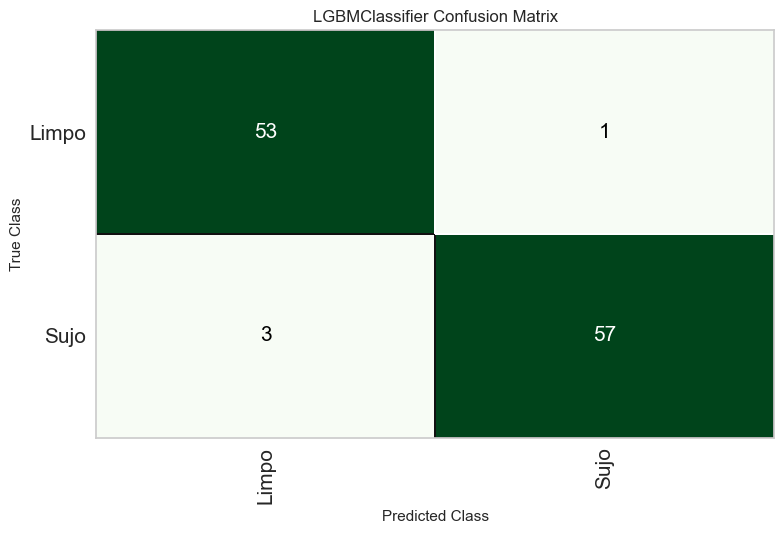

In [ ]:
plot_model(clf, 'confusion_matrix')

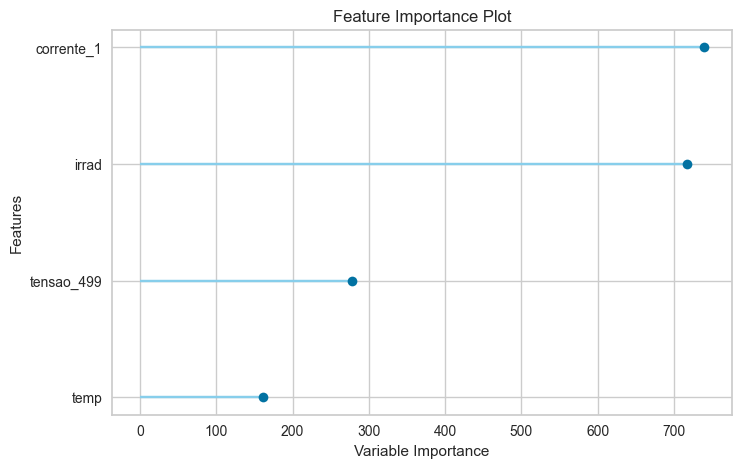

In [ ]:
plot_model(clf, 'feature')

<AxesSubplot:>

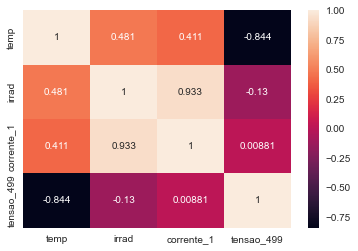

In [7]:
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.3g')

<Figure size 1008x720 with 0 Axes>

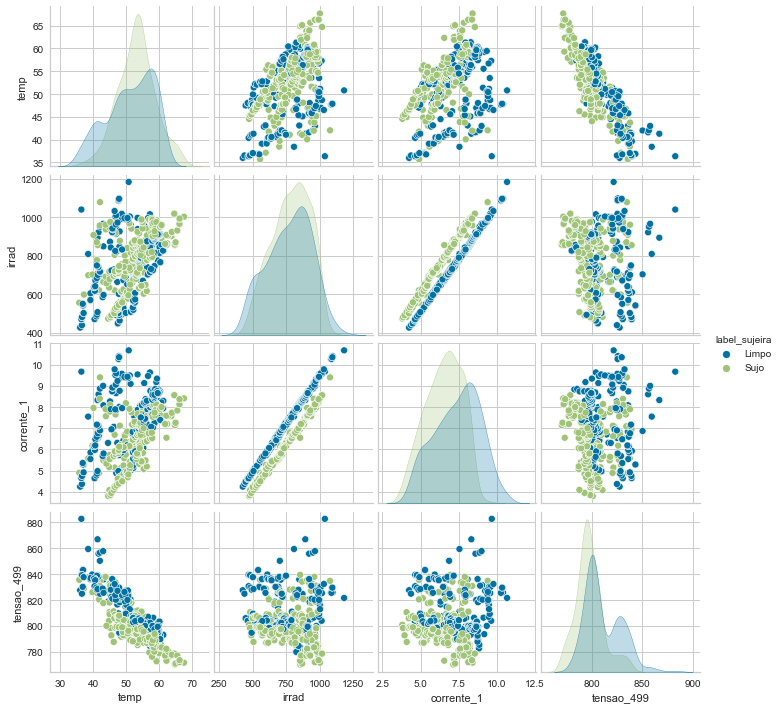

In [11]:
fig = plt.figure(figsize=(14, 10))
sns.pairplot(data=df, hue='label_sujeira')

plt.savefig('figures/pairplot - sujidade - variáveis reamostradas.jpg', corner=True)

In [33]:
df

,irrad,label_sujeira,label_sombra,corrente_1
0,1015.756377,Limpo,Ensaio 1,9.633357
1,1040.200000,Limpo,Ensaio 1,9.670000
2,1094.686567,Limpo,Ensaio 1,10.395877
3,1098.200000,Limpo,Ensaio 1,10.400000
4,1183.952853,Limpo,Ensaio 1,10.673835
...,...,...,...,...
564,931.188316,Sujo,Ensaio 6,7.838541
565,963.136250,Sujo,Ensaio 6,8.126044
566,966.200000,Sujo,Ensaio 6,8.130000
567,990.385958,Sujo,Ensaio 6,8.368906


In [41]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.size'] = 14

In [62]:
rename_mapper = {'irrad': 'Irradiação', 'corrente_1': 'Corrente 1', 'temp': 'Temperatura', 'tensao_499': 'Tensão 499', 'label_sujeira': 'Sujidade'}

sns.set_style(None)
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs.ravel()
sns.scatterplot(data=df.rename(columns=rename_mapper), x='Irradiação', y='Corrente 1', hue='Sujidade', palette=['blue', 'red'], ax=axs[0])
sns.scatterplot(data=df.rename(columns=rename_mapper), x='Temperatura', y='Tensão 499', hue='Sujidade', palette=['blue', 'red'], ax=axs[1])

axs[0].set_title('Relação entre as variáveis: Corrente 1 e Irradiação')
axs[1].set_title('Relação entre as variáveis: Tensão 499 e Temperatura')

sns.set(font_scale=1.2)

plt.tight_layout()
plt.savefig('./scatterplot - sujidade - reamostragem.jpg')
# plt.show()
plt.close()

In [51]:
clf = create_model('ridge', verbose=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9890,0.0000,1.0000,0.9792,0.9895,0.9780,0.9782
Mean,0.9978,0.0000,1.0000,0.9958,0.9979,0.9956,0.9956
Std,0.0044,0.0000,0.0000,0.0083,0.0042,0.0088,0.0087


In [52]:
preds = predict_model(clf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [54]:
df

,temp,irrad,label_sujeira,label_sombra,corrente_1,tensao_499
0,57.27,1015.756377,Limpo,Ensaio 1,9.633357,804.018888
1,36.37,1040.200000,Limpo,Ensaio 1,9.670000,882.700000
2,47.79,1094.686567,Limpo,Ensaio 1,10.395877,825.817566
3,47.79,1098.200000,Limpo,Ensaio 1,10.400000,825.800000
4,50.79,1183.952853,Limpo,Ensaio 1,10.673835,821.633981
...,...,...,...,...,...,...
564,65.62,931.188316,Sujo,Ensaio 6,7.838541,777.155872
565,66.27,963.136250,Sujo,Ensaio 6,8.126044,772.091533
566,66.27,966.200000,Sujo,Ensaio 6,8.130000,772.100000
567,66.30,990.385958,Sujo,Ensaio 6,8.368906,773.632853


In [55]:
sample = df.copy().drop(columns=['label_sombra']).round(1)

In [56]:
sample

,temp,irrad,label_sujeira,corrente_1,tensao_499
0,57.3,1015.8,Limpo,9.6,804.0
1,36.4,1040.2,Limpo,9.7,882.7
2,47.8,1094.7,Limpo,10.4,825.8
3,47.8,1098.2,Limpo,10.4,825.8
4,50.8,1184.0,Limpo,10.7,821.6
...,...,...,...,...,...
564,65.6,931.2,Sujo,7.8,777.2
565,66.3,963.1,Sujo,8.1,772.1
566,66.3,966.2,Sujo,8.1,772.1
567,66.3,990.4,Sujo,8.4,773.6


<Figure size 800x600 with 0 Axes>

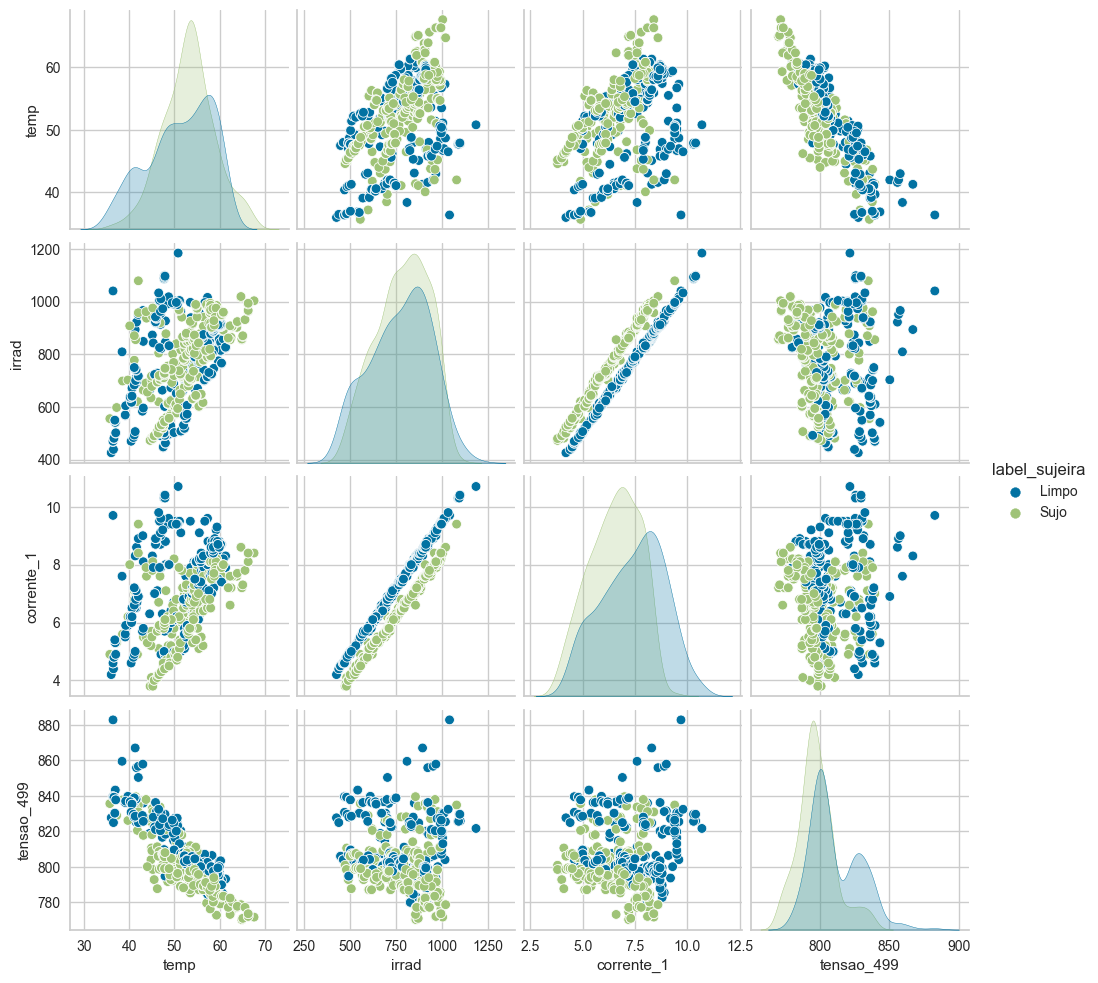

In [60]:
fig = plt.figure(figsize=(8, 6))
sns.pairplot(data=sample, hue='label_sujeira', corner=True)

plt.show()
plt.close()

In [53]:
sns.pairplot?

Signature:
sns.pairplot(
    data,
    *,
    hue=None,
    hue_order=None,
    palette=None,
    vars=None,
    x_vars=None,
    y_vars=None,
    kind='scatter',
    diag_kind='auto',
    markers=None,
    height=2.5,
    aspect=1,
    corner=False,
    dropna=False,
    plot_kws=None,
    diag_kws=None,
    grid_kws=None,
    size=None,
)
Docstring:
Plot pairwise relationships in a dataset.

By default, this function will create a grid of Axes such that each numeric
variable in ``data`` will by shared across the y-axes across a single row and
the x-axes across a single column. The diagonal plots are treated
differently: a univariate distribution plot is drawn to show the marginal
distribution of the data in each column.

It is also possible to show a subset of variables or plot different
variables on the rows and columns.

This is a high-level interface for :class:`PairGrid` that is intended to
make it easy to draw a few common styles. You should use :class:`PairGrid`
directly if you